<a href="https://colab.research.google.com/github/ayotomiwaa/aml-numerai-2/blob/ezekiel-branch/Numerai_Variance_Inflation_Factor_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle lazypredict pandas-profiling

# Inline plots
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 100.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires

## 1. Dataset  

At a high level, the Numerai dataset is a tabular dataset that describes the stock market over time.

Each row represents a stock at a specific point in time, where `id` is the stock id and the `era` is the date. The `features` describe the attributes of the stock (eg. P/E ratio) known on the date and the `target` is a measure of 20-day returns.

The unique thing about Numerai's dataset is that it is `obfuscated`, which means that the underlying stock ids, feature names, and target definitions are anonymized. This makes it so that we can give this data out for free and so that it can be modeled without any financial domain knowledge (or bias!).

### Downloading the Dataset

In [2]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# Print all files available for download in the latest dataset
[f for f in napi.list_datasets() if f.startswith("v4.2")]

['v4.2/features.json',
 'v4.2/live_benchmark_models.parquet',
 'v4.2/live_example_preds.csv',
 'v4.2/live_example_preds.parquet',
 'v4.2/live_int8.parquet',
 'v4.2/meta_model.parquet',
 'v4.2/train_benchmark_models.parquet',
 'v4.2/train_int8.parquet',
 'v4.2/validation_benchmark_models.parquet',
 'v4.2/validation_example_preds.csv',
 'v4.2/validation_example_preds.parquet',
 'v4.2/validation_int8.parquet']

In [3]:
import pandas as pd
import json

# # Download the training data and feature metadata
# # This will take a few minutes 🍵
napi.download_dataset("v4.2/train_int8.parquet");
napi.download_dataset("v4.2/features.json");

v4.2/train_int8.parquet: 1.88GB [01:42, 18.4MB/s]                            
v4.2/features.json: 1.03MB [00:00, 3.45MB/s]                           


In [4]:
# Load only the "medium" feature set to reduce memory usage and speedup model training (required for Colab free tier)
# Use the "all" feature set to use all features
feature_metadata = json.load(open("v4.2/features.json"))
feature_cols = feature_metadata["feature_sets"]["medium"]
train = pd.read_parquet("v4.2/train_int8.parquet", columns=["era"] + feature_cols + ["target"])

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::100])]
train

,era,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_additive_untrustworthy_hierologist,feature_adsorbed_blizzardy_burlesque,feature_affettuoso_taxidermic_greg,...,feature_wistful_tussive_cycloserine,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,target
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0,4,0,4,2,0,1,4,0,...,4,0,0,2,4,2,4,2,2,0.25
n003bee128c2fcfc,0001,4,2,2,2,2,3,1,3,2,...,3,3,3,2,0,2,2,3,2,0.75
n0048ac83aff7194,0001,4,4,2,0,2,0,4,1,3,...,0,0,1,2,0,2,3,1,2,0.25
n00691bec80d3e02,0001,1,4,1,1,2,0,2,1,2,...,0,2,1,2,2,2,3,2,2,0.75
n00b8720a2fdc4f2,0001,0,2,0,0,2,0,3,1,0,...,3,1,1,2,0,2,0,1,2,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nff897cee6baed9c,0501,2,2,4,0,0,1,3,2,4,...,1,2,1,1,4,1,2,2,1,0.75
nffb9d99f6a86ac3,0501,0,0,0,1,3,0,4,2,0,...,2,3,0,1,0,0,4,0,2,0.25
nffc3bcc28eff6b9,0501,1,2,3,2,4,2,1,4,3,...,3,3,3,1,2,0,1,3,3,0.50


### Eras
As mentioned above, each `era` corresponds to a different date. Each era is exactly 1 week apart.

It is helpful to think about rows of stocks within the same `era` as a single example. You will notice that throughout this notebook and other examples, we often talk about things "per era". For example, the number of rows per era represents the number of stocks in Numerai's investable universe on that date.

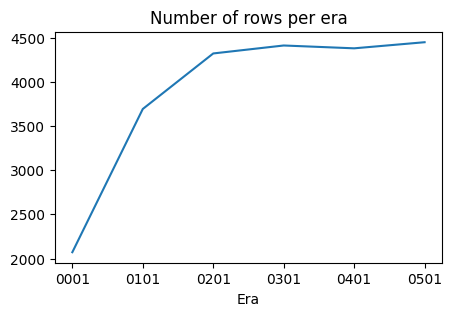

In [5]:
# Plot the number of rows per era
train.groupby("era").size().plot(title="Number of rows per era", figsize=(5, 3), xlabel="Era");

## Variance Inflation Factor

In [7]:
data = train.drop(['era','target'],axis=1).iloc[: ,:5]
# Convert int8 columns to float64
for col in data.select_dtypes(include=['int8']).columns:
    data[col] = data[col].astype('float64')

In [8]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'data' is your Numerai dataset loaded as a pandas DataFrame
# Replace 'data' with the name of your DataFrame

# Select only the numerical features for VIF calculation
numerical_features = data.select_dtypes(include=['float64', 'int64'])

# Threshold for VIF
vif_threshold = 5.0  # You can adjust this threshold as needed

# DataFrames to store the final results
remaining_columns = pd.DataFrame(columns=['feature', 'VIF'])
removed_columns = pd.DataFrame(columns=['feature', 'VIF'])

while True:
    # Calculating VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["feature"] = numerical_features.columns
    vif_data["VIF"] = [variance_inflation_factor(numerical_features.values, i) for i in range(len(numerical_features.columns))]

    # Find max VIF
    max_vif = vif_data['VIF'].max()

    if max_vif > vif_threshold:
        # Find feature with max VIF
        max_vif_feature = vif_data[vif_data['VIF'] == max_vif]['feature'].iloc[0]

        # Add to removed columns
        removed_columns = removed_columns.append({'feature': max_vif_feature, 'VIF': max_vif}, ignore_index=True)

        # Drop the feature with max VIF
        numerical_features.drop(columns=[max_vif_feature], inplace=True)
    else:
        # All VIFs are below the threshold
        remaining_columns = vif_data
        break

print("Remaining Columns:\n", remaining_columns)
print("\nRemoved Columns:\n", removed_columns)

Remaining Columns:
                                     feature       VIF
0      feature_abating_unadaptable_weakfish  2.407843
1         feature_ablest_mauritanian_elding  2.881258
2  feature_acclimatisable_unfeigned_maghreb  3.045985
3        feature_accommodable_crinite_cleft  2.320172
4       feature_accretive_sorrier_skedaddle  2.753361

Removed Columns:
 Empty DataFrame
Columns: [feature, VIF]
Index: []
